# Data Pre-processing Notebook
In this notebook I'm pre-processing the raw data images, mainly by transforing it rom standard RGB images to grayscale ones, stored in 3D samples comprised of 1 gray image per channel.

**Author**: Arthur G.
***

## Loading Dependencies
Loading and setting up all the dependencies for this notebook.

In [1]:
import os
import typing as t

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224

## Helper Functions
In this section I'm writing a set o helper functions to automate data pre-processing.

In [2]:
def load_image_to_dataset(images_dir: str, image_size: tuple = (128, 128)) -> np.ndarray:
    """
    Loads the raw images from a specie folder to an
    array dataset.
    """
    images_array = []
    images_dir_items = os.listdir(images_dir)
    
    # reading raw images as grayscale and storing each three as one sample
    channel_counter = 0
    sample_3d = []
    for image in images_dir_items:
        current_image = cv2.imread(os.path.join(images_dir, image), cv2.IMREAD_GRAYSCALE)
        current_image = cv2.resize(current_image, image_size)
        sample_3d.append(current_image)
        
        # checking if a 3D sample got assembled
        channel_counter += 1
        if channel_counter == 3:
            channel_counter = 0
            sample_3d = np.dstack(sample_3d)
            images_array.append(sample_3d)
            sample_3d = []
            
    return np.array(images_array)

def image_augmentator(
    data_list: np.ndarray,
    img_width: int,
    img_height: int,
    n_channels: int,
    n_samples: int
) -> list:
    """
    Augments the original dataset generating n_samples per
    image of the original dataset.
    """
    augmented_sets = []
    
    # iterating over datasets list
    for data in data_list:
        data = np.reshape(data, (-1, img_height, img_width, n_channels))

        # image generator
        image_generator = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )

        # image augmentation iteration
        augmented_images = []
        for image in data:
            augmented = [image_generator.random_transform(image) for _ in range(n_samples)]
            augmented_images.extend(augmented)
        augmented_sets.append(np.array(augmented_images))

    return augmented_sets

def plot_generated_sample(sample: np.ndarray, figsize: tuple = (15, 8)) -> None:
    """
    Plots each image channel in one figure only.
    """
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    axs[0].imshow(sample[:, :, 0])
    axs[1].imshow(sample[:, :, 1])
    axs[2].imshow(sample[:, :, 2])
    
    for ax in axs:
        ax.axis("off")
        
    plt.show()

## Loading Dataset
In this section I'm loading the raw images from each specie folder to it's own array dataset.

In [3]:
# images directories paths
ANOLIS_PATH = os.path.join("..", "data", "raw", "anolis_fuscoauratus")
HOPLOCERCUS_PATH = os.path.join("..", "data", "raw", "hoplocercus_spinosus")
POLYCHRUS_PATH = os.path.join("..", "data", "raw", "polychrus_marmoratus")

# loaded image datasets
anolis = load_image_to_dataset(images_dir=ANOLIS_PATH, image_size=(IMG_HEIGHT, IMG_WIDTH))
hoplocercus = load_image_to_dataset(images_dir=HOPLOCERCUS_PATH, image_size=(IMG_HEIGHT, IMG_WIDTH))
polychrus = load_image_to_dataset(images_dir=POLYCHRUS_PATH, image_size=(IMG_HEIGHT, IMG_WIDTH))

print(f"Anolis dataset size: {anolis.shape}")
print(f"Hoplocercus dataset size: {hoplocercus.shape}")
print(f"Polychrus dataset size: {polychrus.shape}")

Anolis dataset size: (49, 224, 224, 3)
Hoplocercus dataset size: (22, 224, 224, 3)
Polychrus dataset size: (9, 224, 224, 3)


## Splitting Sets
In this section I'm splitting train, test and validation sets for avoiding data leakage problems. The distribution used is 70% - 20% - 10%, for train, test and validation.

In [4]:
# anolis datasets
anolis_train_set = anolis[0:34, :, :, :]
anolis_test_set = anolis[34:44, :, :, :]
anolis_valid_set = anolis[44:, :, :, :]

# hoplocercus datasets
hoplocercus_train_set = hoplocercus[0:15, :, :, :]
hoplocercus_test_set = hoplocercus[15:19, :, :, :]
hoplocercus_valid_set = hoplocercus[19:, :, :, :]

# polychrus datasets
polychrus_train_set = polychrus[0:6, :, :, :]
polychrus_test_set = polychrus[6:8, :, :, :]
polychrus_valid_set = polychrus[8:, :, :, :]

## Data Augmentation
In this section I'm using the TensorFlow's ImageGenerator to perform image data augmentation for each dataset separated above.

In [5]:
anolis_train, anolis_test, anolis_valid = image_augmentator(
    data_list=[anolis_train_set, anolis_test_set, anolis_valid_set],
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    n_channels=3,
    n_samples=60
)

hoplocercus_train, hoplocercus_test, hoplocercus_valid = image_augmentator(
    data_list=[hoplocercus_train_set, hoplocercus_test_set, hoplocercus_valid_set],
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    n_channels=3,
    n_samples=80
)

polychrus_train, polychrus_test, polychrus_valid = image_augmentator(
    data_list=[polychrus_train_set, polychrus_test_set, polychrus_valid_set],
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    n_channels=3,
    n_samples=110
)

print(f"Anolis new shape = Train: {anolis_train.shape} | Test: {anolis_test.shape} | Valid: {anolis_valid.shape}")
print(f"Hoplocercus new shape = Train: {hoplocercus_train.shape} | Test: {hoplocercus_test.shape} | Valid: {hoplocercus_valid.shape}")
print(f"Polychrus new shape = Train: {polychrus_train.shape} | Test: {polychrus_test.shape} | Valid: {polychrus_valid.shape}")

Anolis new shape = Train: (2040, 224, 224, 3) | Test: (600, 224, 224, 3) | Valid: (300, 224, 224, 3)
Hoplocercus new shape = Train: (1200, 224, 224, 3) | Test: (320, 224, 224, 3) | Valid: (240, 224, 224, 3)
Polychrus new shape = Train: (660, 224, 224, 3) | Test: (220, 224, 224, 3) | Valid: (110, 224, 224, 3)


Now I'm generating the target array for each set, using the following map of categories for numbers:
+ Anolis -> 0
+ Hoplocercus -> 1
+ Polychrus -> 2

In [6]:
# anolis targets
anolis_train_target = np.array([0]*2040).reshape((-1,1))
anolis_test_target = np.array([0]*600).reshape((-1,1))
anolis_valid_target = np.array([0]*300).reshape((-1,1))

# hoplocercus targets
hoplocercus_train_target = np.array([1]*1200).reshape((-1,1))
hoplocercus_test_target = np.array([1]*320).reshape((-1,1))
hoplocercus_valid_target = np.array([1]*240).reshape((-1,1))

# polychrus targets
polychrus_train_target = np.array([2]*660).reshape((-1,1))
polychrus_test_target = np.array([2]*220).reshape((-1,1))
polychrus_valid_target = np.array([2]*110).reshape((-1,1))

Now I'm merging each dataset to serialize train, test and validation sets together.

In [7]:
# merging train, test and validation sets
train_data = np.vstack((anolis_train, hoplocercus_train, polychrus_train))
test_data = np.vstack((anolis_test, hoplocercus_test, polychrus_test))
valid_data = np.vstack((anolis_valid, hoplocercus_valid, polychrus_valid))

# merging train, test and validation target arrays
train_targets = np.vstack((anolis_train_target, hoplocercus_train_target, polychrus_train_target))
test_targets = np.vstack((anolis_test_target, hoplocercus_test_target, polychrus_test_target))
valid_targets = np.vstack((anolis_valid_target, hoplocercus_valid_target, polychrus_valid_target))

## Generated Data Visualization
In this last section I'm grabbing one random generated sample and the plotting it.

### Plotting Original Sample

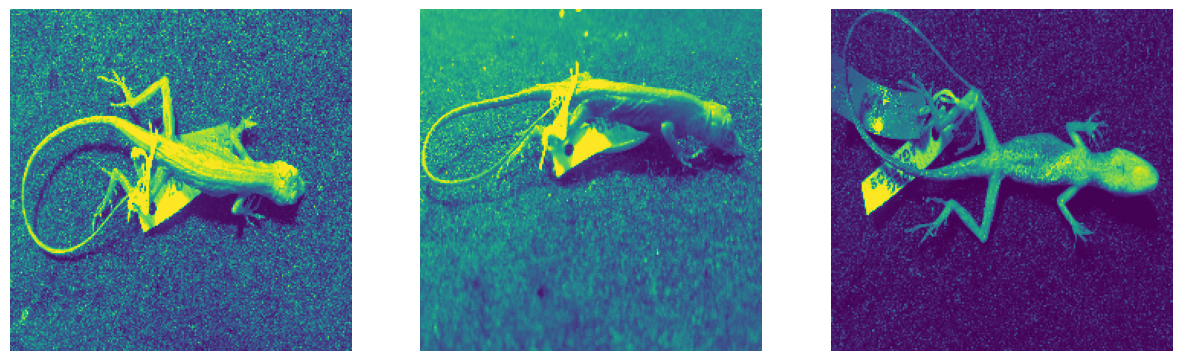

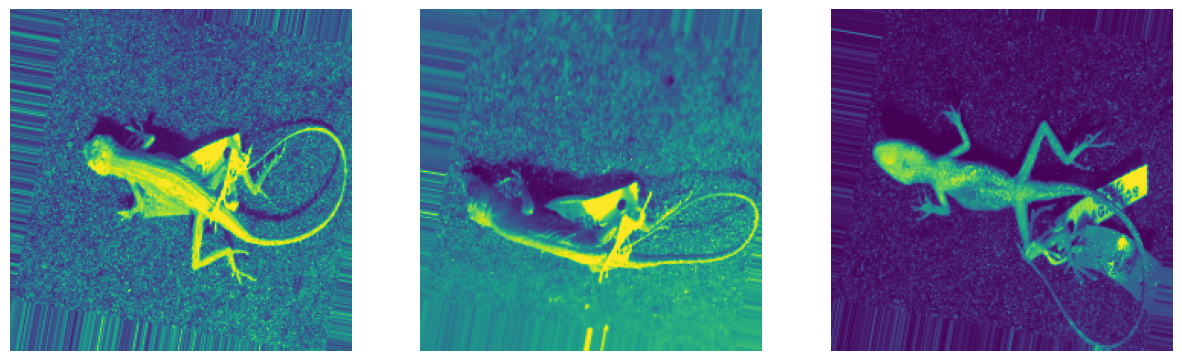

In [19]:
plot_generated_sample(sample=anolis[0])
plot_generated_sample(sample=anolis_train[10])

## Data Serialization
In this last section I'm serializing both the original and the generated datasets.

In [9]:
# serializing original dataset
np.savez(
    os.path.join("..", "data", "processed", "original_image_dataset.npz"),
    images = np.vstack((anolis, hoplocercus, polychrus)),
    targets = np.array([0]*49 + [1]*22 + [2]*9)
)

# serializing generated dataset
np.savez(
    os.path.join("..", "data", "processed", "augmented_image_dataset.npz"),
    train_images = train_data,
    test_images = test_data,
    validation_images = valid_data,
    train_targets = train_targets,
    test_targets = test_targets,
    validation_targets = valid_targets
)